In [ ]:
import osmnx as ox

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import scripts.green_area_analysis as ga

from tqdm.auto import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. Load Static Data

In [3]:
grid = gpd.read_file('../data/yerevan_grid.geojson')
buildings = gpd.read_file('../data/yerevan_buildings.geojson')

G = ox.graph_from_place("Yerevan, Armenia", network_type="all")
nodes, edges = ox.graph_to_gdfs(G)

### 2. Single Instance Detection

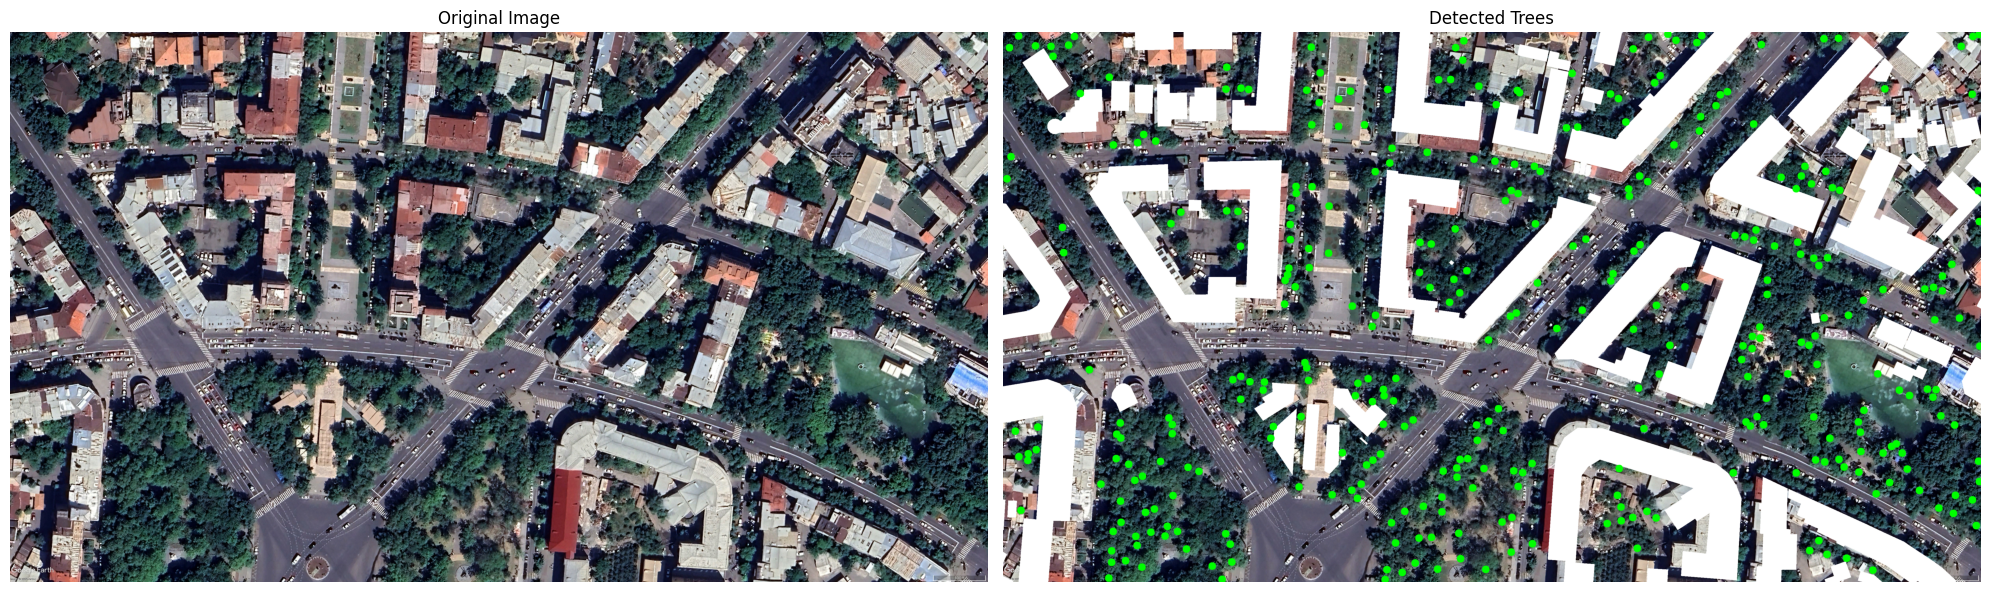

In [ ]:
tile_index = 1381

img_path = f"../images_georef/{tile_index}.tif"

# Step 1: Load image
original_img, transform, crs = ga.read_image_from_path(img_path)

# Step 2: Filter grid, buildings, and roads for the tile
tile_gdf, blds, roads = ga.filter_grid_data(tile_index, grid, buildings, edges)

# Step 3: Mask roads and buildings (make them white)
final_image = ga.paint_buildings_and_roads_white(original_img, blds, roads, transform)

# Step 4: Detect trees and get their estimated centers as lat/lon points
tree_count, tree_img, tree_points = ga.detect_trees_with_canopy_estimation(final_image, transform)

# Step 5: Visualize both original and tree-detected image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(tree_img)
axes[1].set_title(f"Detected Trees")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# Step 6: Convert detected tree centers to GeoDataFrame and assign CRS
trees_gdf = gpd.GeoDataFrame(geometry=tree_points, crs=crs)
trees_gdf = trees_gdf.to_crs(epsg=4326)  # Convert to lat/lon (WGS84)
trees_gdf["img_id"] = tile_index  # Add image index column

### 3. Full Detection Loop

In [ ]:
def detect_trees_around_buildings(tile_index, grid, buildings, edges):
    """
    Detects trees around buildings in a tile with adaptive buffer (25–80m), 
    avoiding overlapping calculations.

    Parameters:
    - tile_index: int, index of the tile
    - grid, buildings, edges: GeoDataFrames

    Returns:
    - trees_gdf: GeoDataFrame with detected tree locations and img_id
    - blds: Filtered buildings for the tile
    - tree_img: Image with tree detections visualized
    - tree_count: Number of detected trees
    """
    from shapely.ops import unary_union

    img_path = f"../images_georef/{tile_index}.tif"
    original_img, transform, crs = ga.read_image_from_path(img_path)

    tile_gdf, blds, roads = ga.filter_grid_data(tile_index, grid, buildings, edges)

    building_count = len(blds)
    if building_count == 0:
        empty = gpd.GeoDataFrame(columns=["geometry", "img_id"], crs="EPSG:4326")
        return empty, blds, original_img, 0

    # Adaptive buffer: more buildings → smaller buffer
    buffer_size = max(30, min(80, 80 - 0.25 * building_count))

    # Mask buildings & roads directly (no copying unless needed)
    base_image = ga.paint_buildings_and_roads_white(original_img, blds, roads, transform)

    # Use in-place buffer + union to define mask zone
    buffered_union = unary_union(blds.geometry.buffer(buffer_size))

    # Clip image using mask geometry
    masked_img, masked_transform = ga.mask_image_by_geometry(base_image, transform, buffered_union)

    # Tree detection (canopy estimation etc.)
    tree_count, tree_img, tree_points = ga.detect_trees_with_canopy_estimation(masked_img, masked_transform)

    # # Show detection image
    # plt.figure(figsize=(12, 8))
    # plt.imshow(tree_img)
    # plt.title(f"Detected Trees: {tree_count} (Tile {tile_index})")
    # plt.axis("off")
    # plt.show()

    # GeoDataFrame of detected trees
    trees_gdf = gpd.GeoDataFrame(geometry=tree_points, crs=crs).to_crs(epsg=4326)
    trees_gdf["img_id"] = tile_index

    return trees_gdf, blds, tree_img, tree_count

#### Start the detection over all images

In [8]:
ids = buildings['img_id'].unique()

In [ ]:
all_tree_detections = []
all_buildings = []

for tile_index in tqdm(ids, total=len(ids), desc='Images Processed'):
    trees_gdf, blds, _, _ = detect_trees_around_buildings(tile_index, grid, buildings, edges)
    
    all_tree_detections.append(trees_gdf)
    all_buildings.append(blds)

# Merge all detections into a single GeoDataFrame
merged_trees_gdf = gpd.GeoDataFrame(pd.concat(all_tree_detections, ignore_index=True), crs=trees_gdf.crs)
merged_buildings_gdf = gpd.GeoDataFrame(pd.concat(all_buildings, ignore_index=True), crs=trees_gdf.crs)

In [ ]:
# Example usage
ids = buildings['img_id'].unique()

# detect_trees_around_buildings is assumed to be defined somewhere
merged_trees, merged_buildings = ga.detect_all_trees(
    ids, grid, buildings, edges, detect_func=detect_trees_around_buildings, max_workers=10
)

In [ ]:
merged_trees.to_file('../data/yerevan_trees.geojson')

In [ ]:
merged_buildings['building_id'] = range(len(merged_buildings))
merged_buildings.to_file('../data/yerevan_buildings_with_id.geojson')